In [7]:
# %load /home/dan/.jupyter/firstcell.py
%load_ext autoreload
%autoreload 2

import sys
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#font = {'size'   : 14}
#mpl.rc('font', **font)

import numpy as np
import pandas as pd

import scipy
from scipy import stats

import sklearn
import sklearn.cluster
import sklearn.datasets

import phate
import umap
import scprep
import magic
import meld
import graphtools as gt



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='loading'></a>
## 1. Loading preprocessed data

### Load EB Data (and download if needed)

In [8]:
home = os.path.expanduser('~')
file_path = os.path.join(home, 'scRNAseq', 'EBT_counts.pkl.gz')
if not os.path.exists(file_path):
    scprep.io.download.download_google_drive(id='1Xz0ONnRWp2MLC_R6r74MzNwaZ4DkQPcM',
                        destination=os.path.dirname(file_path))
EBT_counts = pd.read_pickle(file_path)

In [ ]:
metadata = pd.DataFrame([ix.split('_')[1] for ix in data.index], columns=['sample'], index=data.index)

# 2. Visualization

## 3.0 Notes on Visualization

A visualization is a reduction of dimensions
When we talk about data, we often consider the number of observations and the number of dimensions. In single cell RNA-seq, the number of observations is the number of cells in a dataset. In other words, this is the number of rows. The number of dimensions, or number of features, is the number of genes. These are the columns in a gene expression matrix.

In a common experiment you might have 15,000-30,000 genes in a dataset measured across 5,000-100,000 cells. This presents a problem: How do you visually inspect such a dataset? The key is to figure out a way how to draw the relationships between points on a 2-dimensional sheet of paper, or if you add linear perspective, you can squeeze in a third dimension.

There are many, many ways to visualize data. The most common ones are PCA, t-SNE, and MDS. Each of these has their own assumptions and simplifications they use to figure out an optimal 2D representation of high-dimensional data.

Here, we're going to use three common methods: PCA, t-SNE, and PHATE. 

PCA identifies linear combinations of genes such that each combination (called a Principal Component) that explains the maximum variance. t-SNE is a convex optimization algorithm that tries to minimize the divergence between the neighborhood distances of points (the distance between points that are “close”) in the low-dimensional representation and original data space. PHATE is a visualization method developed by the Krishnaswamy lab designed to preserve both global and local structure in a two or three dimensional visualization.


## 3.1 Principle Components Analysis (PCA)



#### How does PCA work?

PCA related eigendecomposition methods are some of the most fundamental dimensionality reduction tools in data science. Many methods, including tSNE and PHATE, first reduce the data using PCA before performing further operations on the data. 

You can find many rigorous descriptions of the PCA algorithm online. Here, we will focus on the intutition. The goal of PCA is to identify a set of orthogonal dimensions (each of which is a linear combination of the input features) that explain the maximum variance in the data. These dimensions are called Principle Components. In the following figure, you can see data in two dimensions:

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/PCA_original_data.png" style="height: 25rem;"/>

This is a simple dataset where the data exists in two dimensions. The axis of maximum variance in this data is going to be some line that goes up and to the right. If you were to identify the first two principle components in this data they would look like the dashed grey lines in the following figure:

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/PCA_PC1.png" style="height: 35.35rem;"/>

PCA then projects the points onto these new axes. Above, we see the projection onto PC1 (the longest dashed line) for a handful of cells denoted by the red arrows. Note that the arrows are orthogonal (perpendicular) to PC1. This is the definition of projection. Below, you can see what the projection of the data onto the first principle component would look like. Here we're doing the simplest dimensionality reduction. We've taken the data from two dimensions to 1 dimension. Notice how some information is lost here. Some points are very close on PC1 that are far in the original data space. Some information loss is unavoidable when reducing dimensions. Notice that if we considered a second PC, we would get that information back.

Visualization is a game of deciding what information you want to keep, and what you're comfortable throwing away. Here, we're looking at two dimensional data, but scRNA-seq usually has 20-30K data points. Some information will definitely be lost when considering only 1 or 2 principle components.

FYI: There exist as many PCs as there are original dimensions of the data, but we usually only consider the first 50-500 for single cell data. 

#### Using PCA on single cell data

We're going to use the PCA implementation from `scikit-learn` (https://scikit-learn.org/stable/), the most popular package for machine learning in Python. In `scikit-learn`, you run PCA by instantiating a [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) estimator object. There is a standard API for interacting with estimators in scikit-learn. All estimators are [Python Classes](https://docs.python.org/3/tutorial/classes.html) that must first be instantiated with the parameters you want to use. For the `PCA` estimator, the most important parameter is the number of components you want to keep. 

The syntax for instantiaing an estimator is:

```python
from sklearn.decompoisition import PCA
pc_op = PCA(n_components=500)
```

Once instantiated, you first `fit` the estimator to the data. Here, fitting refers to identifying the axes of maximum variance in the data. Next, the data you `transform` the data. Here, the transformation is the projection of the data onto the PCs. Most of the time though, you will run both of these steps at once using the `fit_transform` method.

```python
data_pca = PCA.fit_transform(data)
```

Finally, you can plot the first few PCs and see which axes explain the most variance in the data.

In [11]:
from sklearn.decomposition import PCA

pc_op = PCA(n_components=50) # short for PCA operator
data_pca = pc_op.fit_transform(EBT_counts)

# Now we want to store the output into a dataframe that has the same index
# as the EBT_counts dataframe
data_pca = pd.DataFrame(data_pca, index=EBT_counts.index)

In [12]:
data_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
AAACCGTGCAGAAA-1_Day 00-03,-8.732548,-0.593516,-0.778252,-1.156718,-1.841137,-5.151912,-0.904789,-0.314929,-1.924443,0.266286,...,0.456409,-0.280185,0.704339,0.313862,-0.231890,-0.279786,1.915933,0.206964,0.532628,-0.422073
AAACGCACCGGTAT-1_Day 00-03,-11.345622,-3.247807,5.462555,4.033179,0.456470,0.142143,4.291471,-3.814763,-1.174812,-3.648867,...,0.463537,0.539114,-0.839658,0.209832,0.506113,-0.383037,-0.862638,0.238539,-0.469945,0.067000
AAACGCACCTATTC-1_Day 00-03,-13.180168,-3.596091,8.013868,2.643620,-2.989210,0.265727,3.356651,-2.080587,-1.291956,-3.221475,...,-1.206498,-1.445659,0.229002,0.419652,-0.665767,0.041346,0.578537,-0.332070,0.063999,-0.695016
AAAGATCTCTGCTC-1_Day 00-03,-8.465271,1.754193,-0.351846,-0.182780,0.848231,-6.842295,-1.104108,-0.252574,-1.764429,0.952005,...,0.394693,0.037655,0.374066,-0.114964,-1.452394,0.205107,-0.550366,-0.114827,-0.810680,-0.412323
AAAGATCTGGTACT-1_Day 00-03,-11.339075,-3.188207,4.995027,3.219488,-2.078307,0.911120,2.020906,-2.535010,-1.858537,-3.394669,...,1.053450,0.800150,-0.433498,0.331054,0.364897,0.903126,-0.003404,-1.174172,0.483761,1.297593


#### Plotting PCs using `scprep.plot`

The scprep package has a number of handy plotting features that act as a wrapper to `matplotlib`. You should know how to use `matplotlib` for more complicated plotting, but you can make all the plots we need in this tutorial with some help from `scprep`.

The full documentaiton of `scprep.plot` can be found here:

https://scprep.readthedocs.io/en/stable/reference.html#module-scprep.plot

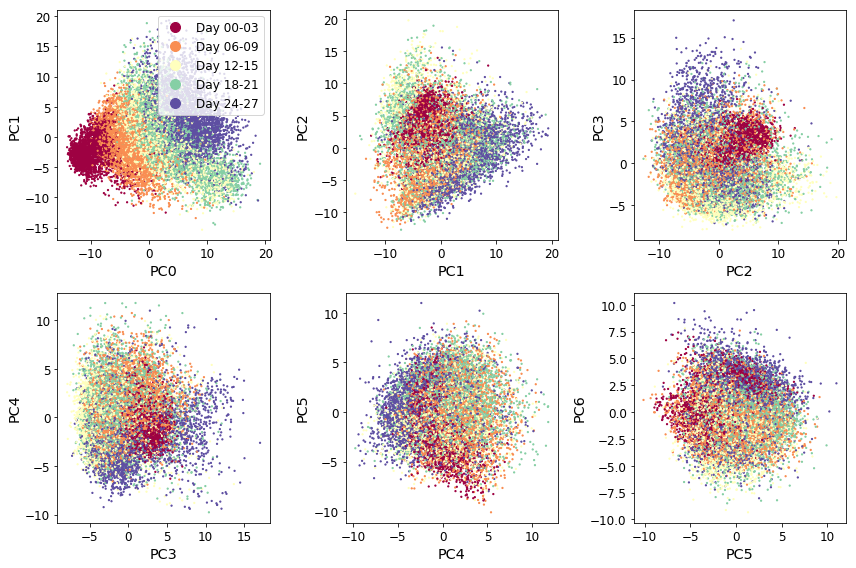

In [17]:

# Create a figure (the background) and a set of axes (the things we plot on)
fig, axes = plt.subplots(2,3, figsize=(12,8))
# This makes it easier to iterate through the axes
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i == 0:
        legend = True
    else:
        legend = False
    # There are a lot of parameters here, you can find the full scatter documentation at
    # https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.scatter
    scprep.plot.scatter(data_pca.iloc[:,i], data_pca.iloc[:,i+1], c=metadata['sample'], cmap='Spectral',
                        ax=ax, xlabel='PC{}'.format(i), ylabel='PC{}'.format(i+1),
                        legend=legend)
fig.tight_layout()

#### Plotting expression of a gene on the first two PCs

Now let's plot expression of some genes!


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


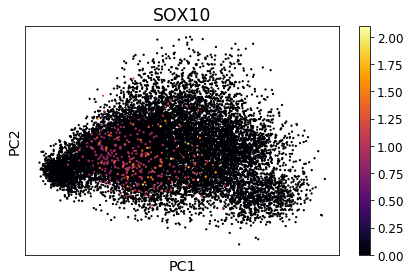

In [18]:
gene = 'SOX10'

expression = scprep.select.select_cols(EBT_counts, starts_with=gene).to_dense()

sort_index = expression.sort_values(by=expression.columns[0]).index

scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                     title=gene, ticks=None, label_prefix='PC')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


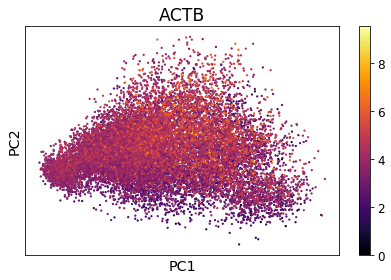

In [19]:
gene = 'ACTB'

expression = scprep.select.select_cols(EBT_counts, starts_with=gene).to_dense()

sort_index = expression.sort_values(by=expression.columns[0]).index

scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                     title=gene, ticks=None, label_prefix='PC')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


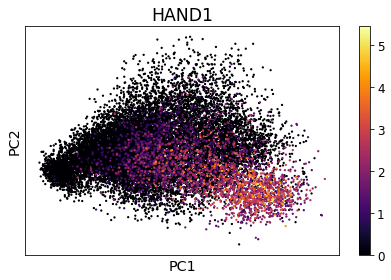

In [20]:
gene = 'HAND1'

expression = scprep.select.select_cols(EBT_counts, starts_with=gene).to_dense()

sort_index = expression.sort_values(by=expression.columns[0]).index

scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                     title=gene, ticks=None, label_prefix='PC')

### Discussion

What do you notice? What does the first principle component track with? What about the second? What do you think the higher PCs represent? What does that mean?

Why did we plot gene expression on the first two PCs?

Look up the function of these genes. What do you notice about where these genes are expressed? What does it mean when a gene is expressed everywhere vs. in one region?

## 3.2 t-SNE

#### What is tSNE?
t-SNE is the most popular visualization method for single cell RNA-sequencing data. The method was first introduced by Laurens van der Maaten in 2008 in the aptly named article ["Visualizing High-Dimensional Data Using t-SNE"](http://jmlr.org/papers/v9/vandermaaten08a.html). The goal of t-SNE is to produce a two or three dimensional embedding of a dataset that exists in many dimensions such that the embedding can be used for visualization.

By embedding, we're talking about projecting the data from high dimensions onto vectors in a smaller space.

The way t-SNE does this is by minimizing the difference between neighborhood distances (i.e. distances from a cell to a set of close cells) in the original high dimensional space and the lower dimensional embedding space. t-SNE is an optimization problem where the algorithm iteratively learns a series of transformations such that each successive transformation better minimizes this difference between the high and low dimensional neighborhood distances. 

This approach preserves local structure in the data. Cells that are close in high dimensional space (i.e. have small Euclidean distances) will also be close in low dimensional space. However, it also means that global structure will not be preserved. This means that the distance between "clusters" in a t-SNE plot don't have any meaning.


#### How to use t-SNE effectively

Unlike PCA, t-SNE has *hyperparameters* these are user-specified options that determine the output of t-SNE. Having hyperparameters isn't bad, but it is essential to understand what the hyperparameters are, what the effect of hyperpameter choices have on output, and how to select the best set of hyperparameters for a given research objective.

In 2016, a group from Google Brain published great essay in Distill about ["How to Use t-SNE Effectively"](https://distill.pub/2016/misread-tsne/). In the article, they provide an interactive tool to explore the effect of various hyperparameters of t-SNE on various datasets.

There are two main hyperparameters for t-SNE: **perplexity** and **learning rate** (sometimes called epsilon). Perplexity determines the "neighborhood size". Larger values of perplexity increase the number of points within the neighborhood. The reccomended range of t-SNE perplexity is roughly 5-50. Learning rate affects how quickly the algorithm "stablilizes". You probably don't need to change this, but should understand what it is.

#### Running t-SNE on the embryoid body data

tSNE is implemented in `scikit-learn`. t-SNE is a manifold learning algorithm and you can find the t-SNE operator at [`sklearn.manifold.TNSE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

We create a t-SNE operator and run it on data just like the PCA operator

```python
from sklearn.manifold import TSNE
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(EBT_counts)
```

### Excercise

In your groups, run TSNE on the EB dataset. Each person should pick a different perplexity. Note, in the following code block, we're using the first 50 PC components to speed up the run time (it should take 3-5 minutes to run). You can try changing the number of PCs and seeing how this affects output after the workshop. Think about why changing the number of PCs affects output.

What are the differences you see?

Try running t-SNE with the same parameters twice. What happens? Why?

In [21]:
from sklearn.manifold import TSNE
# Providing some verbose output. Feel free to comment out these lines
tic = time.time()
print('Calculating tSNE on {} cells...'.format(data_pca.shape[0]))

# Fitting tSNE. Change the perplexity here.
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(data_pca.iloc[:,:50])

# Put output into a dataframe
data_tsne = pd.DataFrame(data_tsne, index=EBT_counts.index)

# More verbose output
toc = time.time()-tic
print('    Ran tSNE in {:.2f} seconds.'.format(toc))

Calculating tSNE on 16821 cells...
    Ran tSNE in 176.63 seconds.


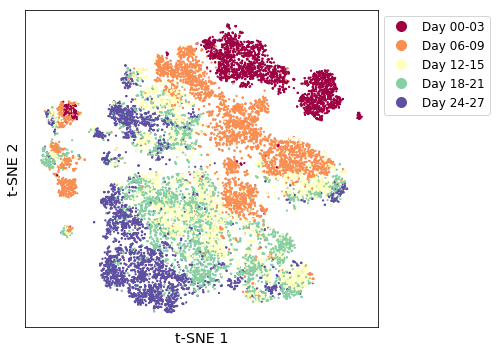

In [26]:
scprep.plot.scatter2d(data_tsne, c=metadata['sample'], cmap='Spectral', 
                      ticks=False, label_prefix='t-SNE ',
                      legend_anchor=(1,1), figsize=(7,5))

#### Let's look at some marker genes!

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


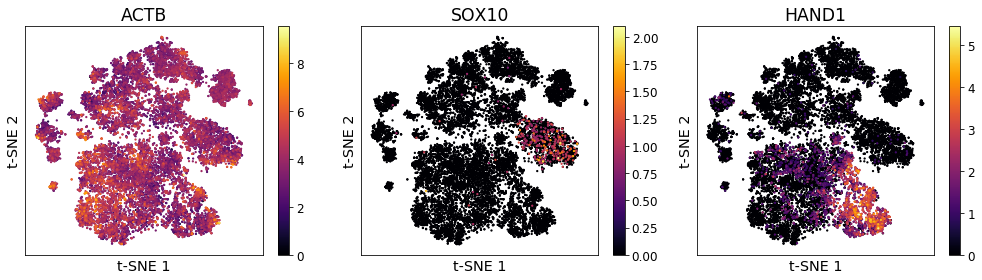

In [23]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
axes = axes.flatten()


genes_for_plotting = ['ACTB', 'SOX10', 'HAND1']

for i, ax in enumerate(axes):
    curr_gene = genes_for_plotting[i]
    

    expression = scprep.select.select_cols(EBT_counts, starts_with=curr_gene).to_dense()
    
    sort_index = expression.sort_values(by=expression.columns[0]).index
    
    scprep.plot.scatter2d(data_tsne.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='t-SNE ', ax=ax)
    
fig.tight_layout()

### Discussion

Now, take some time in your groups to think of some pros and cons of using tSNE. What reccomendations would you give to a new user who wants to know which parameters to try?

## 3.3. Embedding Data Using UMAP

The syntax for UMAP is identical to t-SNE: `umap.UMAP().fit_transform`. UMAP is relatively fast, so you won't need to use the subsampled data.

UMAP's `n_neighbors` parameter describes the size of the neighborhood around each point. The `min_dist` parameter describes how tightly points can be packed together. The authors recommend values between 2 and 200 for `n_neighbors`, and between 0 and 0.99 for `min_dist`. Try a range of different values in and outside of these ranges and discuss the results with your group.

If you have some extra time, play around with the `min_dist` and `n_neighbors` parameters.

In [24]:
import umap
data_umap = umap.UMAP().fit_transform(data_pca.iloc[:,:50])

In [30]:
data_umap = pd.DataFrame(data_umap, index = EBT_counts.index)

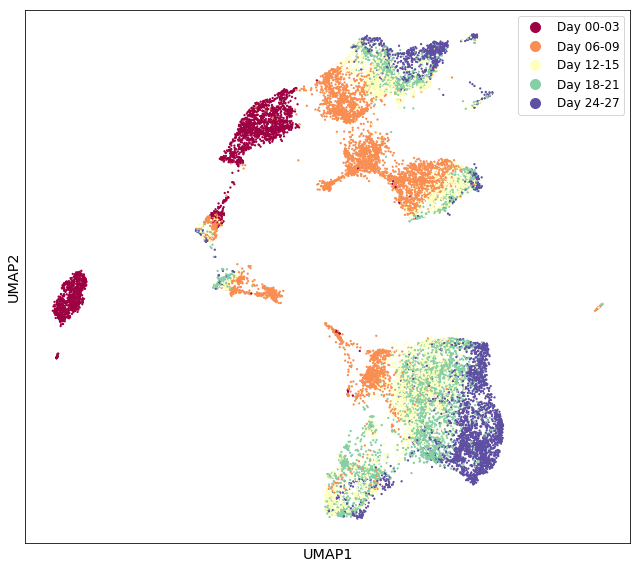

In [31]:
scprep.plot.scatter2d(data_umap, c=metadata['sample'], figsize=(9,8), cmap="Spectral",
                      ticks=False, label_prefix="UMAP")

#### Let's look at some marker genes!

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


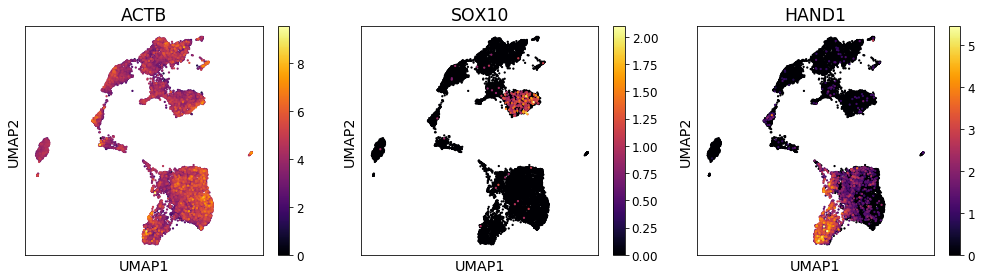

In [33]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
axes = axes.flatten()


genes_for_plotting = ['ACTB', 'SOX10', 'HAND1']

for i, ax in enumerate(axes):
    curr_gene = genes_for_plotting[i]
    

    expression = scprep.select.select_cols(EBT_counts, starts_with=curr_gene).to_dense()
    
    sort_index = expression.sort_values(by=expression.columns[0]).index
    
    scprep.plot.scatter2d(data_umap.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='UMAP', ax=ax)
    
fig.tight_layout()

### Discussion

What are the similarities and differences between UMAP and t-SNE? Do you notice any parameter choices that seem to have similar effects between the algorithms?

## 3.4. Embedding Data Using PHATE

#### How does PHATE work?

PHATE is a dimensionaltiy reduction developed by the Krishnaswamy lab for visualizing high-dimensional data. We use PHATE for *every* dataset the comes through the lab: scRNA-seq, CyTOF, gut microbiome profiles, simulated data, etc. PHATE was designed to handle noisy, non-linear relationships between data points. PHATE produces a low-dimensional representation that preserves both local and global structure in a dataset so that you can make generate hypotheses from the plot about the relationships between cells present in a dataset. Although PHATE has utility for analysis of many data modalities, we will focus on the application of PHATE for scRNA-seq analysis.

PHATE is inspired by diffusion maps [(Coifman et al. 2008.)](https://doi.org/10.1016/j.acha.2006.04.006), but include several key innovations that make it possible to generate a two or three dimensional visualization that preserves continuous relationships between cells where they exist. For a full explanation of the PHATE algorithm, please consult [the PHATE manuscript](https://doi.org/10.1101/120378).

#### Using the PHATE estimator

The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

Like tSNE, PHATE has it's own set of hyperparameters. Changing the parameters will greatly change the output of the algorithm. We reccomend starting with the defaults, then change `knn` and `decay` according the reccomendations below. Generally, we won't select `t` ourselves, but if you're tuning hyperparameters, it's best to fix `t`.

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `k` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `a` increases connectivity on the graph, increasing `a` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.

Here's the simplest way to apply PHATE. Running this should take ~1-3 minutes.

In [34]:
phate_op = phate.PHATE(knn=5, n_jobs=-2)

data_phate = phate_op.fit_transform(data_pca.iloc[:,:50])
data_phate = pd.DataFrame(data_phate, index=EBT_counts.index)

Calculating PHATE...
  Running PHATE on 16821 cells and 50 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 15.86 seconds.
    Calculating affinities...
    Calculated affinities in 0.18 seconds.
  Calculated graph and diffusion operator in 16.07 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.10 seconds.
    Calculating KMeans...
    Calculated KMeans in 20.15 seconds.
  Calculated landmark operator in 23.35 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.80 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.26 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 18.94 seconds.
Calculated PHATE in 59.42 seconds.


And then we plot using `scprep.plot.scatter2d`. For more advanced plotting, we recommend Matplotlib. If you want more help on using Matplotlib, they have [**extensive documentation**](https://matplotlib.org/tutorials/index.html) and [**many Stackoverflow threads**](https://stackoverflow.com/questions/tagged/matplotlib).

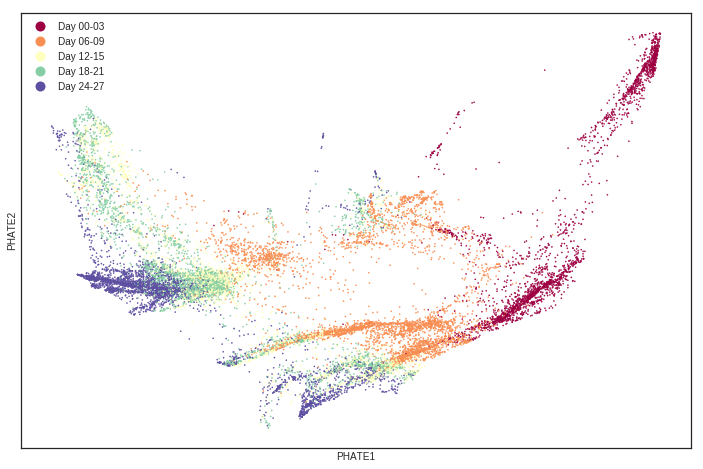

In [0]:
scprep.plot.scatter2d(data_phate, c=metadata['sample'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

Since we are looking for subtle structure and we expect some of the trajectories to be sparse, we might want to decrease `knn` from the default of 5, and reduce `t` from the automatic value of 21 (printed in the output above). For single-cell RNA-seq you can try `knn` as low as 3 or 4 if you're looking for subtle structure, or as high as 30 or 40 if you have hundreds of thousands of cells. We'll also reduce `decay` here to 15 to partially offset the decreased connectivity as a result of decreasing `decay`.

In [0]:
phate_op.set_params(knn=4, decay=15, t=12)
# We could also create a new operator:
#phate_op = phate.PHATE(knn=4, decay=15, t=12, n_jobs=-2)

data_phate = phate_op.fit_transform(data_pca.iloc[:,:50])
data_phate = pd.DataFrame(data_phate, index=EBT_counts.index)

Calculating PHATE...
  Running PHATE on 16821 cells and 50 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 25.72 seconds.
    Calculating affinities...
    Calculated affinities in 2.98 seconds.
  Calculated graph and diffusion operator in 28.83 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 9.76 seconds.
    Calculating KMeans...
    Calculated KMeans in 38.61 seconds.
  Calculated landmark operator in 50.39 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.21 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 10.02 seconds.
Calculated PHATE in 91.46 seconds.


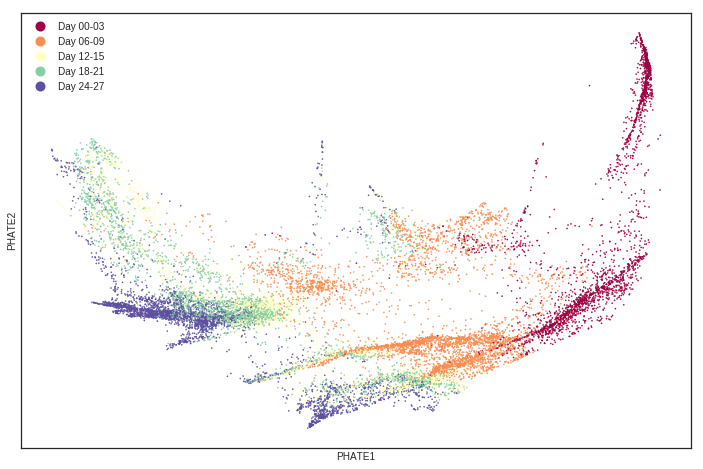

In [0]:
scprep.plot.scatter2d(data_phate, c=metadata['sample'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

#### Gene visualization

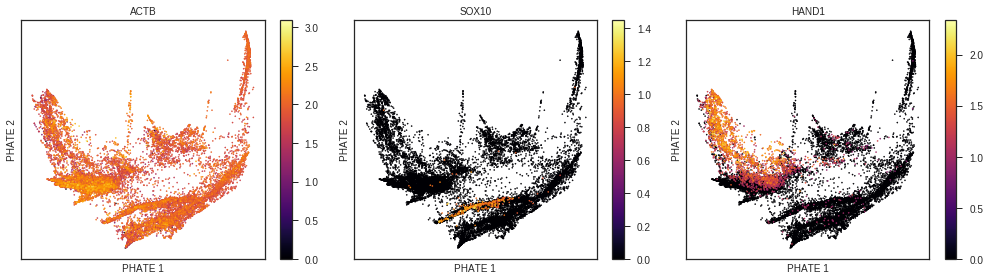

In [0]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
axes = axes.flatten()


genes_for_plotting = ['ACTB', 'SOX10', 'HAND1']

for i, ax in enumerate(axes):
    curr_gene = genes_for_plotting[i]
    

    expression = scprep.select.select_cols(EBT_counts, starts_with=curr_gene).to_dense()
    
    sort_index = expression.sort_values(by=expression.columns[0]).index
    
    scprep.plot.scatter2d(data_phate.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='PHATE ', ax=ax)
    
fig.tight_layout()

### Discussion

Now that you've seen all the methods, how might you include them in a workflow? What are the advantages of each?